# 初期宣言

### Copyright 2022 Google LLC. Double-click for license information.

In [1]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
from huggingface_hub import login
login()

## Null-text inversion + Editing with Prompt-to-Prompt

In [2]:
from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
import torch
from diffusers import StableDiffusion3Pipeline, DDIMScheduler
import torch.nn.functional as nnf
import numpy as np
import abc
import shutil
from torch.optim.adam import Adam
from PIL import Image
from diffusers import StableDiffusion3Pipeline, DDIMInverseScheduler, AutoencoderKL, DDIMScheduler
from torchvision import transforms as tfms

In [3]:
from typing import Union, Tuple, Optional

import matplotlib.pyplot as plt
import torch
from PIL import Image
from diffusers import StableDiffusion3Pipeline, DDIMInverseScheduler, AutoencoderKL, DDIMScheduler, StableDiffusionPipeline
from torchvision import transforms as tvt

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16

In [5]:
import torch

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", 
                                                torch_dtype=torch.float16
                                                )
# pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",torch_dtype=torch.float16).to(device)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [7]:
# pipe.scheduler = DDIMInverseScheduler.from_pretrained('stabilityai/stable-diffusion-3-medium-diffusers', subfolder='scheduler')
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

In [8]:
def load_image(image_path, size=None):
    img = Image.open(image_path).convert("RGB")
    if size is not None:
        img = img.resize(size)
    return img

In [9]:
input_image = load_image("image/MOUSE.png")
input_image_prompt = "An old man wearing a T-shirt that says 'MOUSE'."
with torch.no_grad():
    latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device, dtype=torch.float16) * 2 - 1)
l = 0.18215 * latent.latent_dist.sample()

In [10]:
## Inversion

def invert(
    start_latents,
    prompt,
    guidance_scale=3.5,
    num_inference_steps=80,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt="",
    device=device,
):

    # Encode prompt
    text_embeddings = pipe._encode_prompt(
        prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Latents are now the specified start latents
    latents = start_latents.clone()

    # We'll keep a list of the inverted latents as the process goes on
    intermediate_latents = []

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Reversed timesteps <<<<<<<<<<<<<<<<<<<<
    timesteps = reversed(pipe.scheduler.timesteps)

    for i in tqdm(range(1, num_inference_steps), total=num_inference_steps - 1):

        # We'll skip the final iteration
        if i >= num_inference_steps - 1:
            continue

        t = timesteps[i]

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        current_t = max(0, t.item() - (1000 // num_inference_steps))  # t
        next_t = t  # min(999, t.item() + (1000//num_inference_steps)) # t+1
        alpha_t = pipe.scheduler.alphas_cumprod[current_t]
        alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]

        # Inverted update step (re-arranging the update step to get x(t) (new latents) as a function of x(t-1) (current latents)
        latents = (latents - (1 - alpha_t).sqrt() * noise_pred) * (alpha_t_next.sqrt() / alpha_t.sqrt()) + (
            1 - alpha_t_next
        ).sqrt() * noise_pred

        # Store
        intermediate_latents.append(latents)

    return torch.cat(intermediate_latents)

In [11]:
torch.cuda.empty_cache()

In [12]:
inverted_latents = invert(l, input_image_prompt, num_inference_steps=50)
inverted_latents.shape

AttributeError: 'StableDiffusion3Pipeline' object has no attribute '_encode_prompt'

  0%|          | 0/28 [00:00<?, ?it/s]

Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT b

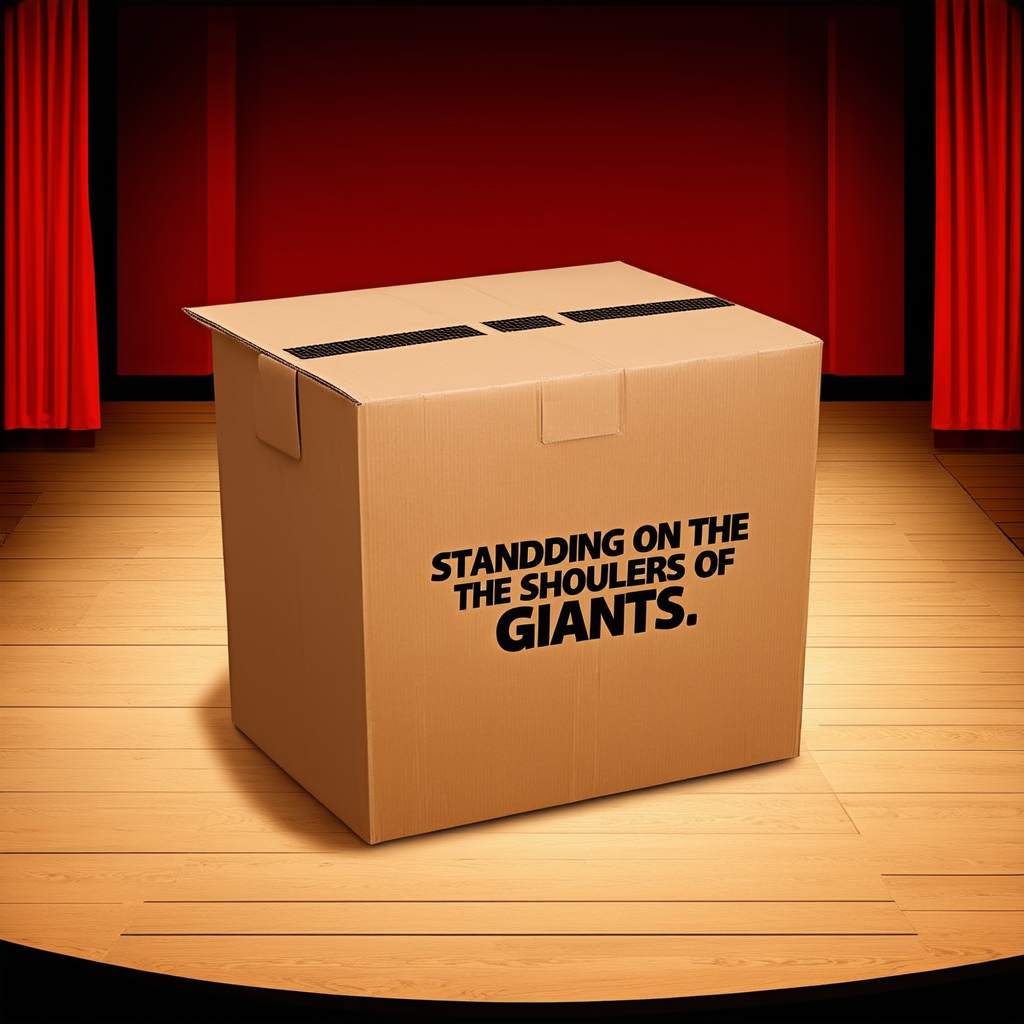

In [7]:
image = pipe(
    "A cardboard box with the phrase “standing on the shoulders of Giants”, the cardboard box is large and sits on a theater stage.",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
).images[0]
image

  0%|          | 0/28 [00:00<?, ?it/s]

Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT b

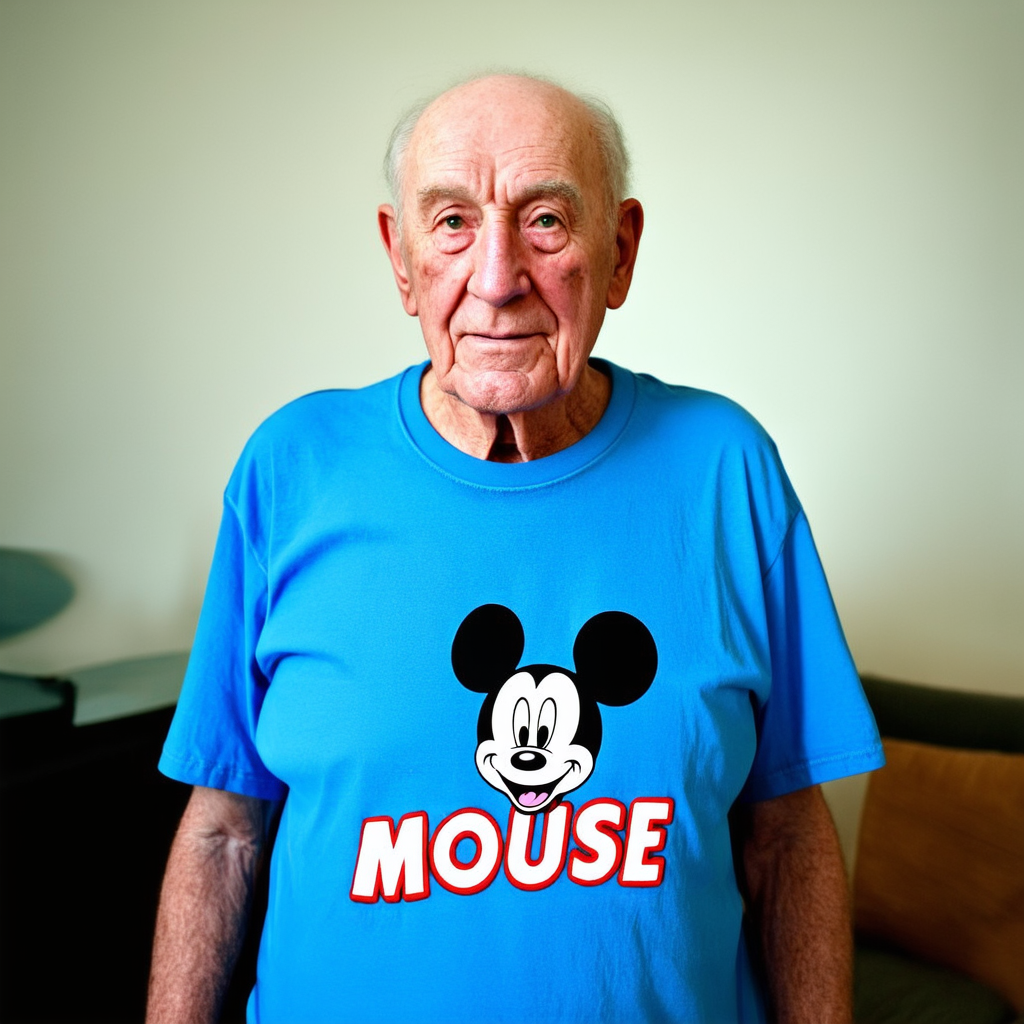

In [16]:
image = pipe(
    "An old man wearing a T-shirt that says 'MOUSE'.",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
).images[0]
image

  0%|          | 0/28 [00:00<?, ?it/s]

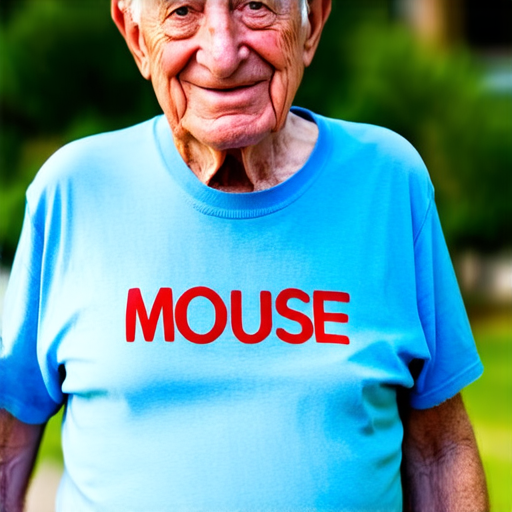

In [8]:
image = pipe(
    "An old man wearing a T-shirt that says 'MOUSE'.",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    width=512,
    height=512
).images[0]
image

  0%|          | 0/28 [00:00<?, ?it/s]

Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT b

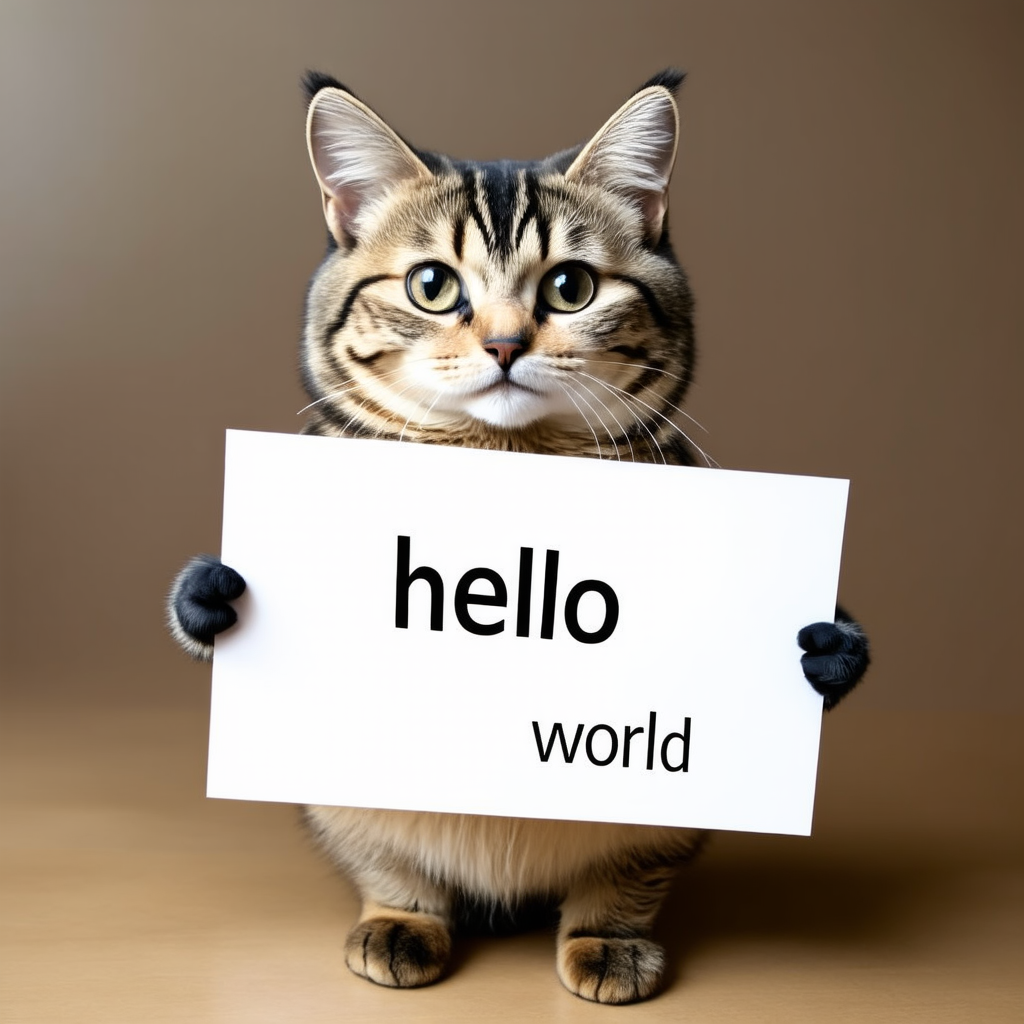

In [22]:
image = pipe(
    "A cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
).images[0]
image

  0%|          | 0/28 [00:00<?, ?it/s]

Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT b

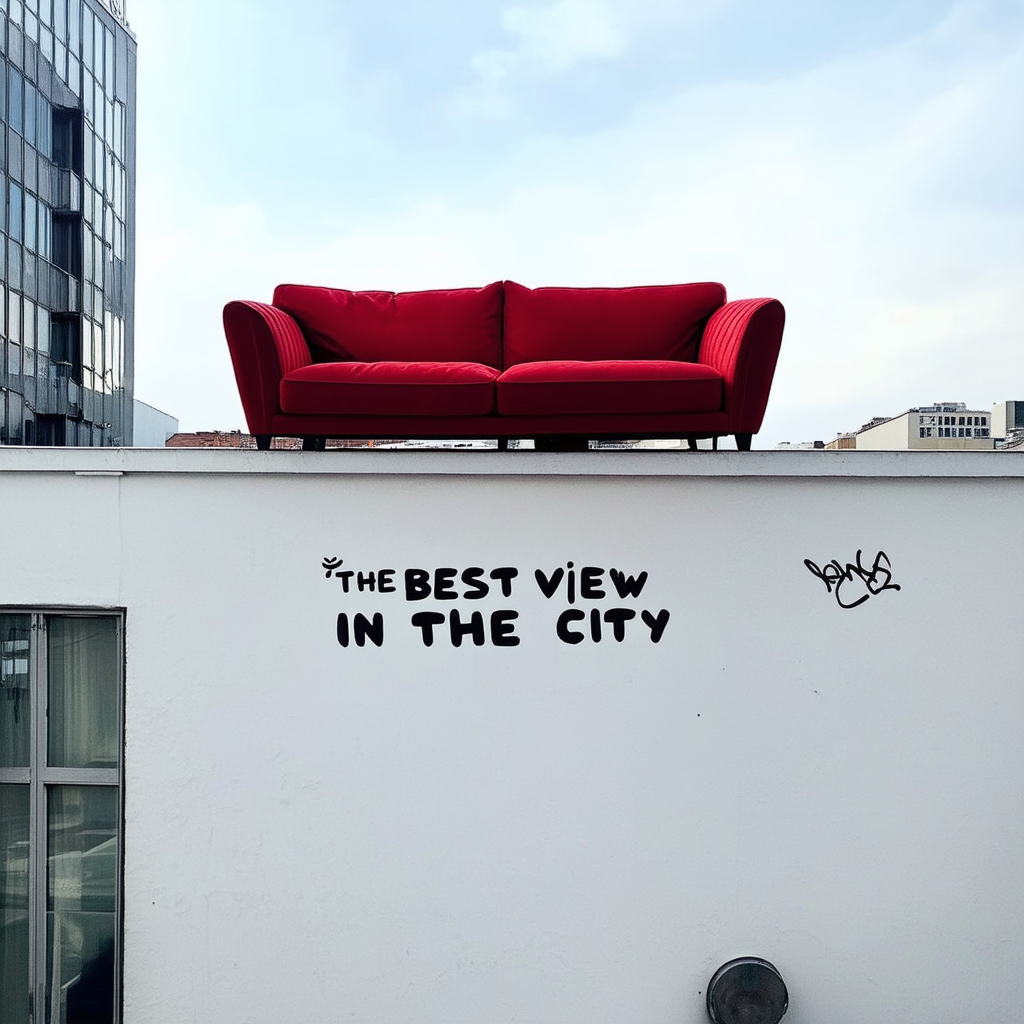

In [20]:
image = pipe(
    "A red sofa on top of a white building. Graffiti with the text “the best view in the city”.",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
).images[0]
image

For loading the Stable Diffusion using Diffusers, follow the instuctions https://huggingface.co/blog/stable_diffusion and update MY_TOKEN with your token.